# Project Kedua: Membuat Model Machine Learning dengan Data Time Series (LSTM)
---
---
* Nama: Benjamin Nikholas
* Email: benjisturi@gmail.com
* Nomor Telp : [6287892677303](wa.me/6287892677303)

Kriteria Parameter:
1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
2. Harus menggunakan LSTM dalam arsitektur model.
3. Validation set sebesar 20% dari total dataset.
4. Model harus menggunakan model sequential.
5. Harus menggunakan Learning Rate pada Optimizer.
6. MAE < 10% skala data.

---

Kriteria target nilai sempurna **(bintang 5)**:
1. dataset yang digunakan memiliki banyak sampel data (>10000)
2. Mengimplementasikan Callback
3. Membuat plot loss dan akurasi pada saat training dan validation

### Library and Packages

In [3]:
import os
import zipfile
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
plt.rcParams['figure.figsize'] = 15, 6
import seaborn as sns
import tensorflow as tf
from keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
import random
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Initialize random number generator to ensure reproducibility

def SetSeed(seed:int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    check_random_state(seed)

### Data Download
---
Data yang digunakan merupakan data crypto BTC/USDT yang didownload dari [kaggle](https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution)


Link lengkap ada dibawah ini:

`https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution`

---

In [4]:
# Install API Kaggle in Google Colaboratory
!pip install kaggle

In [5]:
# Upload API JSON File Credential

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
# Move JSON File and giving access

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download ADA/USD Dataset

!kaggle datasets download -d prasoonkottarathil/btcinusd --file BTC-Hourly.csv
# !kaggle datasets download -d tencars/392-crypto-currency-pairs-at-minute-resolution --file adausd.csv

 97% 1.00M/1.04M [00:00<00:00, 1.23MB/s]
100% 1.04M/1.04M [00:00<00:00, 1.27MB/s]


In [8]:
# Unzip zip file

with zipfile.ZipFile('/content/BTC-Hourly.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

os.listdir('/content')

['.config', 'BTC-Hourly.csv', 'BTC-Hourly.csv.zip', 'sample_data']

### Exploratory Data Analysis

In [9]:
df = pd.read_csv('/content/BTC-Hourly.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33259 entries, 0 to 33258
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        33259 non-null  int64  
 1   date        33259 non-null  object 
 2   symbol      33259 non-null  object 
 3   open        33259 non-null  float64
 4   high        33259 non-null  float64
 5   low         33259 non-null  float64
 6   close       33259 non-null  float64
 7   Volume BTC  33259 non-null  float64
 8   Volume USD  33259 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.3+ MB


In [10]:
# Convert 'date' columns dtype to 'datetime'
df['date'] = pd.to_datetime(df['date'])

# Sorting date
df.sort_values('date', inplace = True)

# Data will be taken from early 2019 to late 2021

start_date = pd.to_datetime('2019-01-01 00:00:00')
# start_date = pd.to_datetime('2018-05-15 06:00:00')
end_date = pd.to_datetime('2022-01-01 00:00:00')
# end_date = pd.to_datetime('2022-03-01 00:00:00')

df = df[(df['date'] >= start_date) & (df['date'] < end_date)]

# Set 'date' column to be the index
df.set_index('date', inplace = True)

# Drop all columns except column 'open'
df = pd.DataFrame(df.iloc[:,2])

# Check data
df.head(5)

,open
date,
2019-01-01 00:00:00,3693.30
2019-01-01 01:00:00,3693.83
2019-01-01 02:00:00,3681.18
2019-01-01 03:00:00,3678.24
2019-01-01 04:00:00,3681.10


In [11]:
# Check new data info

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    26304 non-null  float64
dtypes: float64(1)
memory usage: 411.0 KB


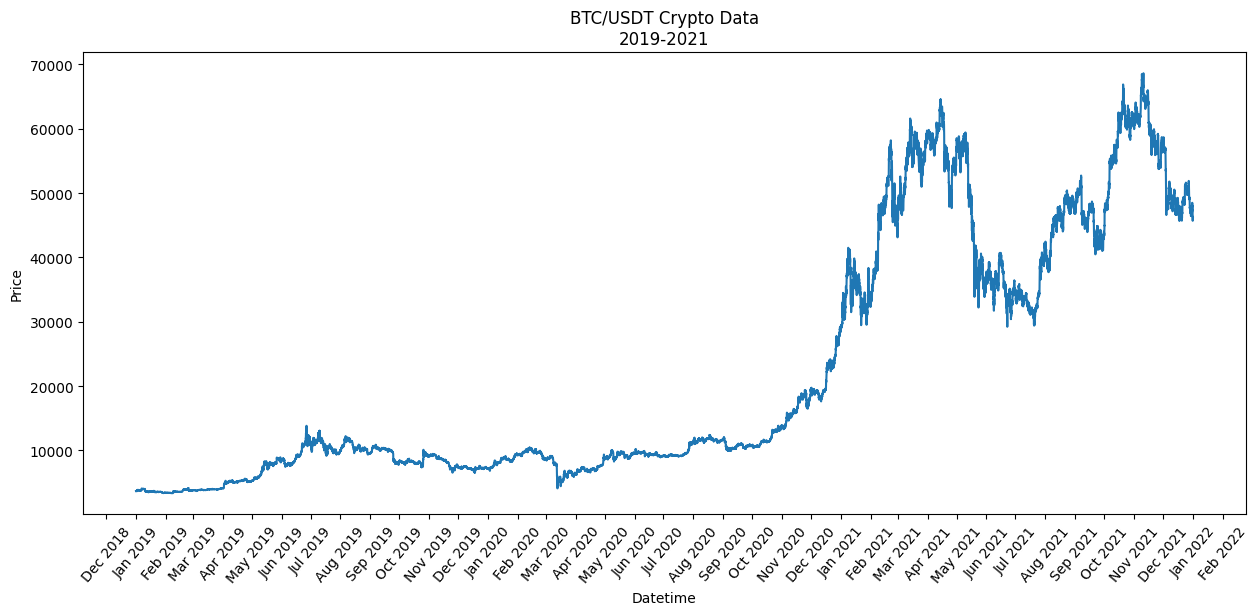

In [12]:
plt.plot(df)

# Menambahkan x-ticks per bulan
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=50)
plt.title('BTC/USDT Crypto Data\n2019-2021')
plt.xlabel('Datetime', fontsize = 10)
plt.ylabel('Price', fontsize = 10)
plt.show()

In [13]:
# Normalize Dataset with MinMaxScaler

Scaler = MinMaxScaler(feature_range = (0, 1))
df_scaled = pd.DataFrame(Scaler.fit_transform(df))

# Sequencing Data

X, y = [], []
time_steps = 1
for i in range(len(df_scaled) - time_steps):
  X.append(df_scaled.iloc[i: (i + time_steps)].values)
  y.append(df_scaled.iloc[i + time_steps])

X, y = np.array(X), np.array(y)

# Split data to train (80%) and validation (20%)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  train_size = 0.8,
                                                  shuffle = False)

In [14]:
# Check X y train and validation data shape

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(21042, 1, 1)
(21042, 1)
(5261, 1, 1)
(5261, 1)


In [15]:
# Initialize threshold mae (10% data)

threshold_mae = (df_scaled.max().values - df_scaled.min().values) * 0.1
print(f'threshold_mae 10% value: {threshold_mae}')

threshold_mae 10% value: [0.1]


### LSTM Modeling

In [16]:
# LSTM Model

SetSeed(2024)

model = Sequential([

    # Add LSTM Layer
    layers.LSTM(128,
                return_sequences = True,
                input_shape=(None, 1)),
    layers.LSTM(64),

    # Add Fully Connected Layer
    layers.Dense(64,
                 activation = 'relu'),
    layers.Dropout(0.1),
    layers.Dense(32,
                 activation = 'relu'),
    layers.Dense(1,
                 activation = 'linear')
])

In [17]:
# Set up Optimizers

SetSeed(2024)

# Adam Optimizer
adam = optimizers.Adam(learning_rate = 0.001)
SGD = optimizers.SGD(learning_rate = 0.1,
                     momentum = 0.9)

# Implement Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'mae',
    min_delta = 0.001,
    verbose = 1,
    patience = 5,
    restore_best_weights = True,
    mode = 'min'
)

In [18]:
# Model Compiling

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = SGD,
              metrics = ['mae'])

In [19]:
# Fitting Model

model_fit = model.fit(X_train, y_train,
                      validation_data = (X_val, y_val),
                      epochs = 10,
                      verbose = 1,
                      callbacks = [EarlyStop],
                      batch_size = 128)

Epoch 1/10
165/165 [==============================] - 7s 18ms/step - loss: 0.0269 - mae: 0.1691 - val_loss: 0.1025 - val_mae: 0.4318
Epoch 2/10
165/165 [==============================] - 2s 10ms/step - loss: 0.0091 - mae: 0.0793 - val_loss: 7.2076e-05 - val_mae: 0.0078
Epoch 3/10
165/165 [==============================] - 2s 9ms/step - loss: 1.6003e-04 - mae: 0.0101 - val_loss: 1.4360e-04 - val_mae: 0.0137
Epoch 4/10
165/165 [==============================] - 2s 14ms/step - loss: 1.4796e-04 - mae: 0.0101 - val_loss: 1.3239e-04 - val_mae: 0.0124
Epoch 5/10
165/165 [==============================] - 3s 15ms/step - loss: 1.3640e-04 - mae: 0.0098 - val_loss: 1.5367e-04 - val_mae: 0.0125
Epoch 6/10
165/165 [==============================] - 2s 11ms/step - loss: 1.3284e-04 - mae: 0.0097 - val_loss: 1.4172e-04 - val_mae: 0.0142
Epoch 7/10
165/165 [==============================] - 2s 10ms/step - loss: 1.3458e-04 - mae: 0.0097 - val_loss: 1.3631e-04 - val_mae: 0.0139
Epoch 8/10
165/165 [======

In [20]:
# Check model fitting history data

history = pd.DataFrame(model_fit.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   loss      8 non-null      float64
 1   mae       8 non-null      float64
 2   val_loss  8 non-null      float64
 3   val_mae   8 non-null      float64
dtypes: float64(4)
memory usage: 384.0 bytes


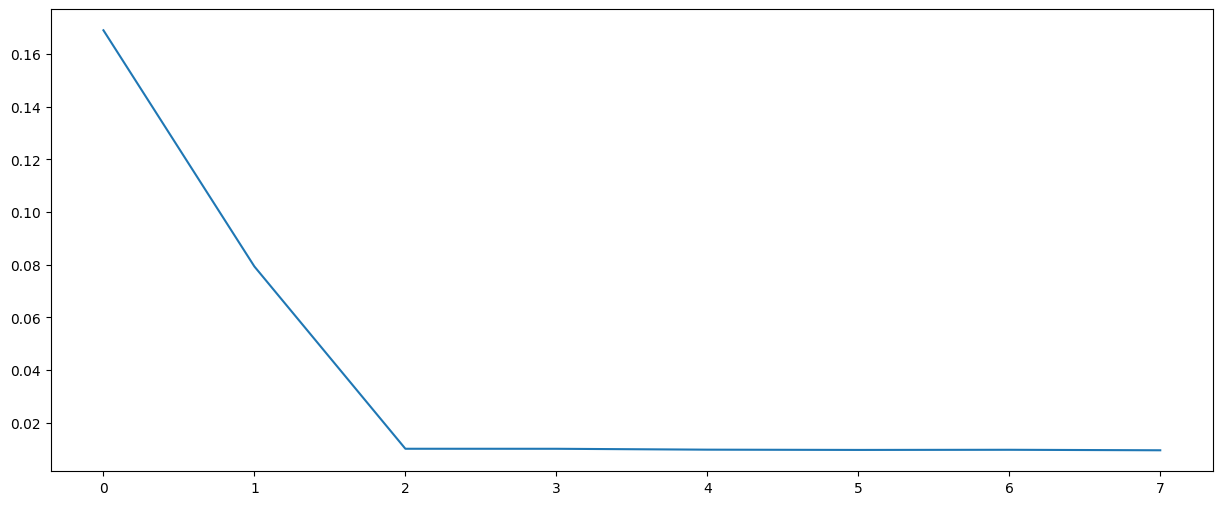

In [21]:
plt.plot(history.mae)

In [22]:
# Check threshold mae test

print(f'MAE Best value < Threshold Mae 10% : {history.mae.min() < threshold_mae}')

MAE Best value < Threshold Mae 10% : [ True]
